In [1]:
## which python is using
## If it is '/media/hcp4715/study/env_py3/bin/python', then, you are working with the PC
## If it is '/opt/miniconda-latest/envs/neuro/bin/python', then, probably, you are working within a container!

import sys
sys.executable

'/opt/miniconda-latest/envs/neuro/bin/python'

In [2]:
%pwd

'/media/hcp4715/Data/Data/RepDopa/BIDS'

### installation

There are two ways to install `nipype`: container or install all images manually.

I tried to use the `nipype_tutorial`(https://miykael.github.io/nipype_tutorial/notebooks/introduction_docker.html), which already included many pakages.

In [3]:
# %%bash
# install the image in a specified disk
# singularity build /media/hcp4715/study/Py_Envs/My_Images/nipype_tutorial.simg docker://miykael/nipype_tutorial:latest


In [4]:
#%%bash
## run the image
## This one works!!
#singularity run --cleanenv -B /media/hcp4715/Data/Data/RepDopa/BIDS:/media/hcp4715/Data/Data/RepDopa/BIDS \
#/media/hcp4715/study/Py_Envs/My_Images/nipype_tutorial.simg \
#jupyter-notebook

### Preprocessing
preprocessing will use the package `nipype`.

install:

`onda install --channel conda-forge nipype`

Import a few things from nipype and external libraries.

In [59]:
%matplotlib inline

import os
from os.path import abspath, join

from nipype import Workflow, Node, MapNode, Function
from nipype.interfaces.fsl import BET, IsotropicSmooth, ApplyMask

from nilearn.plotting import plot_anat
import matplotlib.pyplot as plt

data_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/'
output_dir = '/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/'

### Interface

Interfaces are the core pieces of Nipype. The interface are python modules that allow you to use various external packages (e.g., FSL, SPM,  or FreeSurfer), even if they themselves are written in another programming language than python.


#### Let's try to use bet from FSL:

In [60]:
input_file = join(data_dir, 'sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz')
out_file = join(output_dir, 'output/sub-001_T1w_nipype_bet.nii.gz')
print(input_file)
print(out_file)

/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz
/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/sub-001_T1w_nipype_bet.nii.gz


In [61]:
bet = BET()
bet.inputs.in_file = input_file
bet.inputs.out_file = join(output_dir, 'output/sub-001_T1w_nipype_bet.nii.gz')
bet.cmdline
res = bet.run()

In [62]:
res.outputs


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = <undefined>
meshfile = <undefined>
out_file = /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/sub-001_T1w_nipype_bet.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

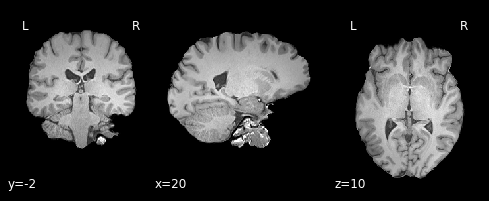

In [63]:
plot_anat(out_file, display_mode='ortho', dim=-1, draw_cross=False, annotate=True)

In [10]:
BET.help()

Wraps the executable command ``bet``.

FSL BET wrapper for skull stripping

For complete details, see the `BET Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> btr = fsl.BET()
>>> btr.inputs.in_file = 'structural.nii'
>>> btr.inputs.frac = 0.7
>>> btr.inputs.out_file = 'brain_anat.nii'
>>> btr.cmdline
'bet structural.nii brain_anat.nii -f 0.70'
>>> res = btr.run() # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                input file to skull strip
                argument: ``%s``, position: 0

        [Optional]
        out_file: (a pathlike object or string representing a file)
                name of output skull stripped image
                argument: ``%s``, position: 1
        outline: (a boolean)
                create surface outline image
                argument: ``-o``
        mask: (a boolean)
                c

### Exercise 1a

Import `IsotropicSmooth` from `nipype.interface.fsl` and find out the FSL commond that is being run. 
What are the mandatory inputs for this interface?

In [64]:
from nipype.interfaces.fsl import IsotropicSmooth

IsotropicSmooth.help()

Wraps the executable command ``fslmaths``.

Use fslmaths to spatially smooth an image with a gaussian kernel.

Inputs::

        [Mandatory]
        fwhm: (a float)
                fwhm of smoothing kernel [mm]
                argument: ``-s %.5f``, position: 4
                mutually_exclusive: sigma
        sigma: (a float)
                sigma of smoothing kernel [mm]
                argument: ``-s %.5f``, position: 4
                mutually_exclusive: fwhm
        in_file: (a pathlike object or string representing an existing file)
                image to operate on
                argument: ``%s``, position: 2

        [Optional]
        out_file: (a pathlike object or string representing a file)
                image to write
                argument: ``%s``, position: -2
        internal_datatype: ('float' or 'char' or 'int' or 'short' or 'double'
                  or 'input')
                datatype to use for calculations (default is float)
                argument: ``-dt

### Exercise 1b

Run `IsotropicSmooth` for `/media/hcp4715/Data/Data/RepDopa/BIDS/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz` file with a smoothing kernel 4mm:

In [65]:
smoothing=IsotropicSmooth()
smoothing.inputs.in_file=input_file
smoothing.inputs.fwhm = 4
smoothing.inputs.out_file=join(output_dir,'output/sub-001_T1w_nipype_smooth.nii.gz')
smoothing.run()

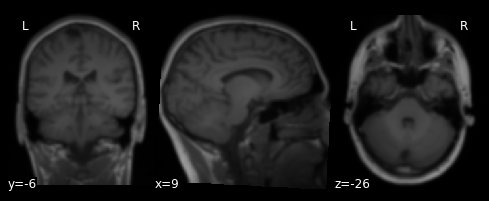

In [66]:
plot_anat(join(output_dir,'output/sub-001_T1w_nipype_smooth.nii.gz'),
         display_mode='ortho', dim=1,draw_cross=False, annotate=True);

In [ ]:
?plot_anat

## Nodes and Workflows

Interfaces are the core pieces of Nipype that run the code of your desire. But to streamline your analysis and to execute multiple interfaces in a sensible order, you have to put them in something that we called a Node and create a Workflow

In Nipype, a node is an object that executes a certain function. This function can be anything from a Nipype interface to a user-specified function or an external script. Each node consists of a name, an interface, and at least one input field and at least one output field.

Once you have multiple nodes, you can use `Workflow` to connect with each other and create a directed graph. `Nipype` workflow will take care of input and output of each interface and arrage the execute of each interface in the most efficient way.


### Let's create the first node using `BET` interface:

In [67]:
# create Node
bet_node = Node(BET(), name='bet')

# Specify node inputs
bet_node.inputs.in_file = input_file
#bet_node.inputs.in_file = "/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz"
bet_node.inputs.mask = True

# bet node can be also defined this way:
# bet_node = Node(BET(in_file=input_file, mask=True), name='bet_node')

In [68]:
print(bet_node.inputs.in_file)
print(input_file)

/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz
/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz


Create a `Node` for Isotropic Smooth interface

In [69]:
smooth_node = Node(IsotropicSmooth(in_file=input_file, fwhm=4), name="smooth")

Now create one more Node for our workflow

In [70]:
mask_node = Node(ApplyMask(), name="mask")

Let's check the `ApplyMask` interface:

In [71]:
ApplyMask.help()

Wraps the executable command ``fslmaths``.

Use fslmaths to apply a binary mask to another image.

Inputs::

        [Mandatory]
        mask_file: (a pathlike object or string representing an existing
                  file)
                binary image defining mask space
                argument: ``-mas %s``, position: 4
        in_file: (a pathlike object or string representing an existing file)
                image to operate on
                argument: ``%s``, position: 2

        [Optional]
        out_file: (a pathlike object or string representing a file)
                image to write
                argument: ``%s``, position: -2
        internal_datatype: ('float' or 'char' or 'int' or 'short' or 'double'
                  or 'input')
                datatype to use for calculations (default is float)
                argument: ``-dt %s``, position: 1
        output_datatype: ('float' or 'char' or 'int' or 'short' or 'double'
                  or 'input')
                d

As you can see, the interface takes two mandatory inputs: `in_file` and `mask_file`. We want to use the output of `smooth_node` as `in_file` and one of the output of `bet_node` (the `mask_file`) as `mask_file` input.


### Let's initialize a `workflow`

In [72]:
wf = Workflow(name="smoothflow", base_dir=join(output_dir,"output/working_dir"))

It's very important to specify `base_dir` (as absolute path), because otherwise all the outputs would be save somewhere in the temporary files.

### Let's connect the `bet_node` output to `mask_node` input

In [73]:
wf.connect(bet_node, "mask_file", mask_node, "mask_file")

connect `out_file` of `smooth_node` to `in_file` of `mask_node`.

In [74]:
wf.connect(smooth_node, "out_file", mask_node, "in_file")

### Let's see a graph describing our workflow:

200214-15:21:03,510 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smooth/workflow_graph.png (graph2use=hierarchical, simple_form=True).


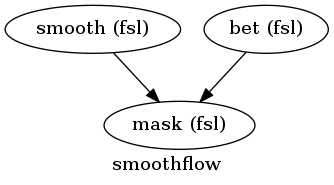

In [75]:
wf.write_graph(join(output_dir, "output/working_dir/smooth/workflow_graph.dot"))

from IPython.display import Image
Image(filename=join(output_dir, "output/working_dir/smooth/workflow_graph.png"))

You can also plot a more detailed graph:

200214-15:21:06,14 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/graph.png (graph2use=flat, simple_form=True).


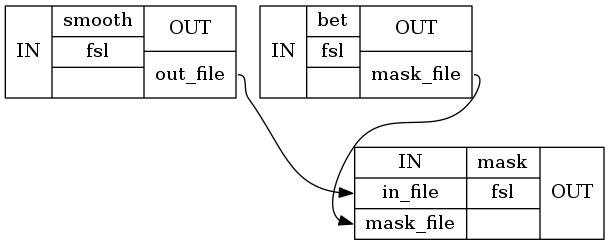

In [76]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename=join(output_dir, "output/working_dir/smoothflow/graph_detailed.png"))

### Now let's run the workflowb

In [77]:
smooth_node.inputs.in_file
input_file

'/media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz'

In [78]:
res = wf.run()

200214-15:21:11,270 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
200214-15:21:11,280 nipype.workflow INFO:
	 Running serially.
200214-15:21:11,281 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/smooth".
200214-15:21:11,293 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz -s 1.69864 /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/smooth/sub-001_ses-d1_T1w_smooth.nii.gz
200214-15:21:21,263 nipype.workflow INFO:
	 [Node] Finished "smoothflow.smooth".
200214-15:21:21,265 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.bet" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/bet".
200214

In [79]:
list(res.nodes)[0].result.outputs


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/bet/sub-001_ses-d1_T1w_brain_mask.nii.gz
meshfile = <undefined>
out_file = <undefined>
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

In [83]:
join(output_dir, 'output/working_dir/smoothflow/')

'/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/'

In [84]:
! tree -L 3 {'/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/'}

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow/
├── bet
│   ├── _0xd6b0b81a08cd52607fc3300c7585137b.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_bet.pklz
│   └── sub-001_ses-d1_T1w_brain_mask.nii.gz
├── d3.js
├── graph1.json
├── graph_detailed.dot
├── graph_detailed.png
├── graph.dot
├── graph.json
├── graph.png
├── index.html
├── mask
│   ├── _0xa7b298c95b7561e20f445baa613a6693.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_mask.pklz
│   └── sub-001_ses-d1_T1w_smooth_masked.nii.gz
├── smooth
│   ├── _0x7f5774a1315a293a99b527dd0a7129b4.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_smooth.pklz
│   └── sub-001_ses-d1_T1w_smooth.nii.gz
└── smooth_node
    ├── command.txt
    ├── _inputs.pklz
    ├── _node.pklz
    ├── _report
    │   └── rep

### and we can plot the results:

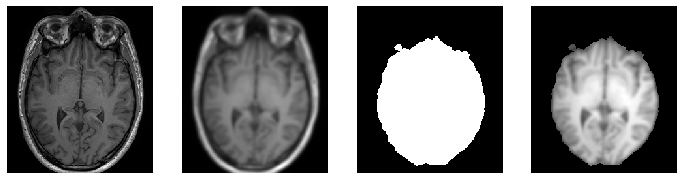

In [85]:
import numpy as np
import nibabel as nb
# import matplotlib.pyplot as plt

# let's create a short helper function to plot 3D Nifti images:

def plot_slice(fname):
    
    # load the image
    img = nb.load(fname)
    data = img.get_data()
    
    # Cut in the middle of the brain
    cut = int(data.shape[-1]/2) + 10
    
    # plot the data
    plt.imshow(np.rot90(data[..., cut]), cmap="gray")
    plt.gca().set_axis_off()
    
f = plt.figure(figsize=(12,4))

for i, img in enumerate([join(data_dir, "sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz"),
                        join(output_dir, "output/working_dir/smoothflow/smooth/sub-001_ses-d1_T1w_smooth.nii.gz"),
                        join(output_dir, "output/working_dir/smoothflow/bet/sub-001_ses-d1_T1w_brain_mask.nii.gz"),
                        join(output_dir, "output/working_dir/smoothflow/mask/sub-001_ses-d1_T1w_smooth_masked.nii.gz")]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)

## Interables

Some steps in a neuroimaging analysis are repetitive. Running the same preprocessing on multiple subjects or doding statistical inference on multiple files. To prevent the creation of multiple individual scripts, Nipype has an execution plugin for `Workflow`, called `iterables`.

Let's assume we have a workflow with two nodes, node (A) does simple skull stripping, and is followed by a node (B) that does isomeric smoothing. Now let's say, that we are curious about the effect of different smoothing kernels. Therefore, we want to run the smoothing node with FWHM set to 2mm, 8mm, and 16mm.

In [86]:
smooth_node_it = Node(IsotropicSmooth(in_file=input_file), name="smooth")
smooth_node_it.iterables = ("fwhm", [4, 8, 16])

We will define again bet and smooth nodes:

In [87]:
bet_node_it = Node(BET(in_file=input_file, mask=True), name="bet_node")
mask_node_it = Node(ApplyMask(), name="mask")

In [88]:
# create a workflow with a new `base_dir`:

# Initiaion of a workflow:
wf_it = Workflow(name="smoothflow_it", base_dir=join(output_dir, "output/working_dir"))
wf_it.connect(bet_node_it, "mask_file", mask_node_it, "mask_file")
wf_it.connect(smooth_node_it, "out_file", mask_node_it, "in_file")

In [89]:
# let's run the workflow and check the output
res_it = wf_it.run()

200214-16:21:57,844 nipype.workflow INFO:
	 Workflow smoothflow_it settings: ['check', 'execution', 'logging', 'monitoring']
200214-16:21:57,864 nipype.workflow INFO:
	 Running serially.
200214-16:21:57,864 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow_it.smooth" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow_it/_fwhm_16/smooth".
200214-16:21:57,870 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /media/hcp4715/Data/Data/RepDopa/BIDS/Nifti/sub-001/ses-d1/anat/sub-001_ses-d1_T1w.nii.gz -s 6.79457 /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow_it/_fwhm_16/smooth/sub-001_ses-d1_T1w_smooth.nii.gz
200214-16:22:26,170 nipype.workflow INFO:
	 [Node] Finished "smoothflow_it.smooth".
200214-16:22:26,171 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow_it.smooth" in "/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/out

### Let's see the graph

In [91]:
list(res_it.nodes)

[smoothflow_it.bet_node,
 smoothflow_it.mask.a0,
 smoothflow_it.smooth.aI.a0,
 smoothflow_it.mask.a1,
 smoothflow_it.smooth.aI.a1,
 smoothflow_it.mask.a2,
 smoothflow_it.smooth.aI.a2]

200214-16:24:58,387 nipype.workflow INFO:
	 Generated workflow graph: /media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow_it/workflow_graph.png (graph2use=hierarchical, simple_form=True).


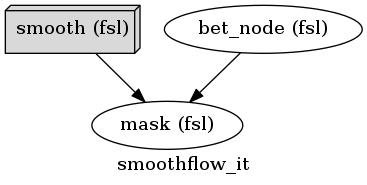

In [93]:
wf_it.write_graph(join(output_dir, "output/working_dir/smoothflow_it/workflow_graph.dot"))

from IPython.display import Image
Image(filename=join(output_dir, "output/working_dir/smoothflow_it/workflow_graph.png"))

We can see the file structure that was created:

In [94]:
! tree -L 3 {'/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow_it/'}

/media/hcp4715/Data/Data/RepDopa/BIDS/learnPy_out/output/working_dir/smoothflow_it/
├── bet_node
│   ├── _0xd6b0b81a08cd52607fc3300c7585137b.json
│   ├── command.txt
│   ├── _inputs.pklz
│   ├── _node.pklz
│   ├── _report
│   │   └── report.rst
│   ├── result_bet_node.pklz
│   └── sub-001_ses-d1_T1w_brain_mask.nii.gz
├── d3.js
├── _fwhm_16
│   ├── mask
│   │   ├── _0x7c664624a7fd97039ec17f6fbe00ae03.json
│   │   ├── command.txt
│   │   ├── _inputs.pklz
│   │   ├── _node.pklz
│   │   ├── _report
│   │   ├── result_mask.pklz
│   │   └── sub-001_ses-d1_T1w_smooth_masked.nii.gz
│   └── smooth
│       ├── _0x3ee404079d5a6ed1ad43f76032d278bd.json
│       ├── command.txt
│       ├── _inputs.pklz
│       ├── _node.pklz
│       ├── _report
│       ├── result_smooth.pklz
│       └── sub-001_ses-d1_T1w_smooth.nii.gz
├── _fwhm_4
│   ├── mask
│   │   ├── _0x32ff3bf621186e6c1e83085b2c52a2c2.json
│   │   ├── command.txt
│   │   ├── _inputs.pklz
│   │   ├── _node.pklz
│   │   ├── _report
│   │   ├── r

## MapNode

if you want to iterate over a list of inputs, but need to feed all iterated outputs afterwards as one input (an array) to the next node, you need to use a `MapNode`. A `MapNode` is quite similar to a normal `Node`, but it can take a list of inputs and operate over each input separately, ultimately returning a list of outputs.

Imagine that you have a list of items (let's say files) and you want to execute the same node on them (for example some smoothing or maksing). Some nodes accept multiple files and do exactly the same thing on them, but some don't (they expect only one file). `MapNode` can solve this problem. Imagine you have the following workflow:

Node `A` outputs a list of files, but node `B` accepts only one file. Additionally, `C` expect a list of files. What yo uwould like is to run `B` for every file in the output of `A` and collect the results as a list and feed it to `C`.

### Let's run a simple numerical example using nipype `Function` interface

In [96]:
def square_func(x):
    return x ** 2

square = Function(input_names=["x"], output_names=["f_x"], function=square_func)

In [97]:
square_node = Node(square, name="square")
square_node.inputs.x = 2
res = square_node.run()
res.outputs

200214-16:42:45,240 nipype.workflow INFO:
	 [Node] Setting-up "square" in "/tmp/tmpfsthlmn7/square".
200214-16:42:45,243 nipype.workflow INFO:
	 [Node] Running "square" ("nipype.interfaces.utility.wrappers.Function")
200214-16:42:45,246 nipype.workflow INFO:
	 [Node] Finished "square".



f_x = 4

In [98]:
#Let's try to ask for more values of `x`

square_node = Node(square, name='square')
square_node.inputs.x = [2, 4]
res = square_node.run()
res.outputs

200214-16:54:40,431 nipype.workflow INFO:
	 [Node] Setting-up "square" in "/tmp/tmpk_d129iz/square".
200214-16:54:40,434 nipype.workflow INFO:
	 [Node] Running "square" ("nipype.interfaces.utility.wrappers.Function")
200214-16:54:40,436 nipype.workflow WARNING:
	 [Node] Error on "square" (/tmp/tmpk_d129iz/square)


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

### It will give an error since `square_func` do not accept list. But we can try `MapNode`:

In [99]:
square_mapnode = MapNode(square, name="square", iterfield=["x"])
square_mapnode.inputs.x = [2, 4]
res = square_mapnode.run()
res.outputs

200214-16:58:55,51 nipype.workflow INFO:
	 [Node] Setting-up "square" in "/tmp/tmp5bxjz292/square".
200214-16:58:55,55 nipype.workflow INFO:
	 [Node] Setting-up "_square0" in "/tmp/tmp5bxjz292/square/mapflow/_square0".
200214-16:58:55,57 nipype.workflow INFO:
	 [Node] Running "_square0" ("nipype.interfaces.utility.wrappers.Function")
200214-16:58:55,60 nipype.workflow INFO:
	 [Node] Finished "_square0".
200214-16:58:55,61 nipype.workflow INFO:
	 [Node] Setting-up "_square1" in "/tmp/tmp5bxjz292/square/mapflow/_square1".
200214-16:58:55,67 nipype.workflow INFO:
	 [Node] Running "_square1" ("nipype.interfaces.utility.wrappers.Function")
200214-16:58:55,70 nipype.workflow INFO:
	 [Node] Finished "_square1".
200214-16:58:55,73 nipype.workflow INFO:
	 [Node] Finished "square".


Bunch(f_x=[4, 16])